#### Loading the data

In [1]:
# importing the libraries necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, LSTM

In [2]:
# importing the data
# starting with just 3 datasets, restricting to 2000 as earliest time
filepaths = ['../../data/AMZN_1997-05-15_2022-08-17.csv', '../../data/SPY_1993-01-29_2022-08-17.csv', '../../data/GOOGL_2004-08-19_2022-08-17.csv']

amazon_df = pd.read_csv(filepaths[0])
spy_df = pd.read_csv(filepaths[1])
goog_df = pd.read_csv(filepaths[2])

In [3]:
amazon_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [4]:
spy_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.438103,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.619028,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.673309,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,25.944679,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.053232,531500


In [5]:
goog_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,2.511011,893181924
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044


In [6]:
print(len(amazon_df.set_index('Date')['2005-01-01':]))
print(len(spy_df.set_index('Date')['2005-01-01':]))
print(len(goog_df.set_index('Date')['2005-01-01':]))

4437
4437
4437


In [7]:
amazon_close = amazon_df.set_index('Date')['2005-01-01':]['Close']
spy_close = spy_df.set_index('Date')['2005-01-01':]['Close']
goog_close = goog_df.set_index('Date')['2005-01-01':]['Close']

amazon_close.index = pd.to_datetime(amazon_close.index)
spy_close.index = pd.to_datetime(spy_close.index)
goog_close.index = pd.to_datetime(goog_close.index)

In [8]:
data = pd.concat([amazon_close, spy_close, goog_close],  axis=1)
data.columns = ['amz', 'spy', 'goog']

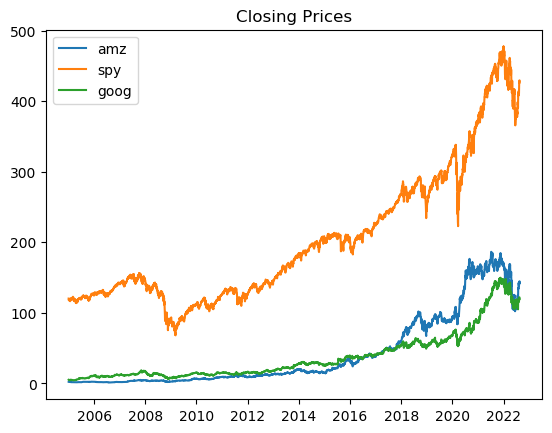

In [9]:
for col in data.columns:
    plt.plot(data[col], label=col)

plt.title('Closing Prices')
plt.legend()
plt.show();

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forcast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
series_to_supervised(data, 5, 3).head()

,var1(t-5),var2(t-5),var3(t-5),var1(t-4),var2(t-4),var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),...,var3(t-1),var1(t),var2(t),var3(t),var1(t+1),var2(t+1),var3(t+1),var1(t+2),var2(t+2),var3(t+2)
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-10,2.2260,120.300003,5.072823,2.1070,118.830002,4.867367,2.0885,118.010002,4.842593,2.0525,...,4.851101,2.0920,119.000000,4.881381,2.0820,118.180000,4.843343,2.1150,118.570000,4.889389
2005-01-11,2.1070,118.830002,4.867367,2.0885,118.010002,4.842593,2.0525,118.610001,4.718468,2.1160,...,4.881381,2.0820,118.180000,4.843343,2.1150,118.570000,4.889389,2.1300,117.620003,4.888138
2005-01-12,2.0885,118.010002,4.842593,2.0525,118.610001,4.718468,2.1160,118.440002,4.851101,2.0920,...,4.843343,2.1150,118.570000,4.889389,2.1300,117.620003,4.888138,2.2275,118.239998,5.004254
2005-01-13,2.0525,118.610001,4.718468,2.1160,118.440002,4.851101,2.0920,119.000000,4.881381,2.0820,...,4.889389,2.1300,117.620003,4.888138,2.2275,118.239998,5.004254,2.2290,119.470001,5.102603
2005-01-14,2.1160,118.440002,4.851101,2.0920,119.000000,4.881381,2.0820,118.180000,4.843343,2.1150,...,4.888138,2.2275,118.239998,5.004254,2.2290,119.470001,5.102603,2.1980,118.220001,4.937437


In [12]:
def prep_data(data, p_test, n_lag, n_seq, stationary=True):
    '''
    series - dataset to transform
    p_test - percentage of test set size
    n_lag - number of previous days to take into account
    n_seq - number of days to predict
    stationary - boolean determining if the series should be differenced
    returns -> train, test, scaler
    '''
    # transform series into train and test sets
    ret_values = data
    if stationary:
        ret_values = data.diff().dropna()
    
    # rescale series between (-1, 1)
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaled_values = scaler.fit_transform(ret_values)
    
    # Transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    
    # split into train and test sets
    split_val = int(len(data) * (1 - p_test))
    train, test = supervised_values[:split_val], supervised_values[split_val:]
    return train, test, scaler

In [13]:
def fit_lstm(train, n_lag, n_pred, n_batch, nb_epoch, n_neurons, n_seq):
    '''
    train - dataset to train on
    n_lag - number of previous days to take into account
    n_pred - number of days to predict
    n_batch - batch_size
    nb_epoch - epoch number
    n_neurons - number of neurons in the layer, probably going to be changed
    n_seq - number of sequences we are looking at
    returns -> train, test, scaler
    '''
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag * n_seq], train[:, n_lag * n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    #defining the moddel
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
    model.add(Dropout(.2))
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=False))
    model.add(Dropout(.2))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # fit the model
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [14]:
hist_len = 14
prediction_len = 3
train, test, scaler = prep_data(data, .2, hist_len, prediction_len)

In [15]:
model = fit_lstm(train, hist_len, prediction_len, 1, 25, 10, 3)
model.summary()

3549/3549 [==============================] - 25s 7ms/step - loss: 0.0024
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 10)                2120      
                                                                 
 dropout (Dropout)           (1, 1, 10)                0         
                                                                 
 lstm_1 (LSTM)               (1, 10)                   840       
                                                                 
 dropout_1 (Dropout)         (1, 10)                   0         
                                                                 
 dense (Dense)               (1, 9)                    99        
                                                                 
Total params: 3,059
Trainable params: 3,059
Non-trainable params: 0
_______________________________________________

In [16]:
def forecast_lstm(model, X, n_batch):
    # reshape to a 3d vector pattern of [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make the forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

def make_forecasts(model, n_batch, train, test, n_lag, n_pred, n_seq):
    forecasts = list()
    for i in range(len(test)):
        print('Working on %d out of %d...' % (i, len(test)))
        X, y = test[i, 0:n_lag * n_seq], test[i, n_lag * n_seq:]
        forecast = forecast_lstm(model, X, n_batch)
        forecasts.append(forecast)
    return forecasts

In [17]:
print(len(test[0]), len(train[0]))

51 51


In [18]:
forecasts = make_forecasts(model, 1, train, test, hist_len, prediction_len, 3)

Working on 0 out of 871...
1/1 [==============================] - 1s 660ms/step
Working on 1 out of 871...
1/1 [==============================] - 0s 16ms/step
Working on 2 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 3 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 4 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 5 out of 871...
1/1 [==============================] - 0s 16ms/step
Working on 6 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 7 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 8 out of 871...
1/1 [==============================] - 0s 16ms/step
Working on 9 out of 871...
1/1 [==============================] - 0s 17ms/step
Working on 10 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 11 out of 871...
1/1 [==============================] - 0s 18ms/step
Working on 12 out of 871...
1/1 [================

1/1 [==============================] - 0s 14ms/step
Working on 103 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 104 out of 871...
1/1 [==============================] - 0s 13ms/step
Working on 105 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 106 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 107 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 108 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 109 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 110 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 111 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 112 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 113 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 114 out of 871...
1/1 [=======================

1/1 [==============================] - 0s 15ms/step
Working on 204 out of 871...
1/1 [==============================] - 0s 16ms/step
Working on 205 out of 871...
1/1 [==============================] - 0s 17ms/step
Working on 206 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 207 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 208 out of 871...
1/1 [==============================] - 0s 16ms/step
Working on 209 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 210 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 211 out of 871...
1/1 [==============================] - 0s 16ms/step
Working on 212 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 213 out of 871...
1/1 [==============================] - 0s 19ms/step
Working on 214 out of 871...
1/1 [==============================] - 0s 13ms/step
Working on 215 out of 871...
1/1 [=======================

1/1 [==============================] - 0s 14ms/step
Working on 305 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 306 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 307 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 308 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 309 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 310 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 311 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 312 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 313 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 314 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 315 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 316 out of 871...
1/1 [=======================

1/1 [==============================] - 0s 19ms/step
Working on 406 out of 871...
1/1 [==============================] - 0s 16ms/step
Working on 407 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 408 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 409 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 410 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 411 out of 871...
1/1 [==============================] - 0s 16ms/step
Working on 412 out of 871...
1/1 [==============================] - 0s 17ms/step
Working on 413 out of 871...
1/1 [==============================] - 0s 16ms/step
Working on 414 out of 871...
1/1 [==============================] - 0s 17ms/step
Working on 415 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 416 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 417 out of 871...
1/1 [=======================

1/1 [==============================] - 0s 16ms/step
Working on 507 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 508 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 509 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 510 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 511 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 512 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 513 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 514 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 515 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 516 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 517 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 518 out of 871...
1/1 [=======================

1/1 [==============================] - 0s 15ms/step
Working on 608 out of 871...
1/1 [==============================] - 0s 13ms/step
Working on 609 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 610 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 611 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 612 out of 871...
1/1 [==============================] - 0s 18ms/step
Working on 613 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 614 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 615 out of 871...
1/1 [==============================] - 0s 13ms/step
Working on 616 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 617 out of 871...
1/1 [==============================] - 0s 13ms/step
Working on 618 out of 871...
1/1 [==============================] - 0s 13ms/step
Working on 619 out of 871...
1/1 [=======================

1/1 [==============================] - 0s 15ms/step
Working on 709 out of 871...
1/1 [==============================] - 0s 19ms/step
Working on 710 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 711 out of 871...
1/1 [==============================] - 0s 13ms/step
Working on 712 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 713 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 714 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 715 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 716 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 717 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 718 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 719 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 720 out of 871...
1/1 [=======================

1/1 [==============================] - 0s 15ms/step
Working on 810 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 811 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 812 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 813 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 814 out of 871...
1/1 [==============================] - 0s 16ms/step
Working on 815 out of 871...
1/1 [==============================] - 0s 16ms/step
Working on 816 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 817 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 818 out of 871...
1/1 [==============================] - 0s 13ms/step
Working on 819 out of 871...
1/1 [==============================] - 0s 14ms/step
Working on 820 out of 871...
1/1 [==============================] - 0s 15ms/step
Working on 821 out of 871...
1/1 [=======================

In [19]:
def inverse_diff(last_ob, forecast):
    inverted = []
    inverted.append(forecast[0] + last_ob)
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

def inverse_transform(series, forecasts, scaler, n_test, stationary = True):
    inverted = []
    for i in range(len(forecasts)):
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(3, int(len(forecast)/3))
        #invert the scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing if enabled
        temp = inv_scale
        if stationary:
            index = len(series) - n_test + i - 1
            last_ob = series.values[index]
            temp = inverse_diff(last_ob, inv_scale)
        inverted.append(temp)
    return inverted

In [20]:
readable = inverse_transform(data, forecasts, scaler, len(test) + 2)

In [21]:
readable[0]

[array([ 83.48104188, 280.31455323,  57.32053849]),
 array([ 83.27504785, 280.10855921,  57.11454447]),
 array([ 83.20803471, 280.04154606,  57.04753132])]

In [22]:
def evaluate_forecasts(test, forecasts, n_lag, n_pred):
    for i in range(n_pred):
        actual_amz = [row[i][0] for row in test]
        actual_spy = [row[i][1] for row in test]
        actual_goog = [row[i][2] for row in test]
        predicted_amz = [forecast[i][0] for forecast in forecasts]
        predicted_spy = [forecast[i][1] for forecast in forecasts]
        predicted_goog = [forecast[i][2] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual_amz, predicted_amz))
        print('t+%d RMSE_amz: %f' %((i+1), rmse))
        rmse = sqrt(mean_squared_error(actual_spy, predicted_spy))
        print('t+%d RMSE_spy: %f' %((i+1), rmse))
        rmse = sqrt(mean_squared_error(actual_goog, predicted_goog))
        print('t+%d RMSE_goog: %f' %((i+1), rmse))
        
def plot_forecasts(series, forecasts, n_test):
    plt.plot(series.values)
    
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    plt.show()

In [23]:
readable[0]

[array([ 83.48104188, 280.31455323,  57.32053849]),
 array([ 83.27504785, 280.10855921,  57.11454447]),
 array([ 83.20803471, 280.04154606,  57.04753132])]

In [24]:
actual = [row[hist_len * 3:] for row in test]
actual = inverse_transform(data, actual, scaler, len(test)+2, True)

evaluate_forecasts(actual, readable, hist_len, prediction_len)

t+1 RMSE_amz: 3.179579
t+1 RMSE_spy: 3.179579
t+1 RMSE_goog: 3.179579
t+2 RMSE_amz: 7.770339
t+2 RMSE_spy: 7.770339
t+2 RMSE_goog: 7.770339
t+3 RMSE_amz: 9.449230
t+3 RMSE_spy: 9.449230
t+3 RMSE_goog: 9.449230


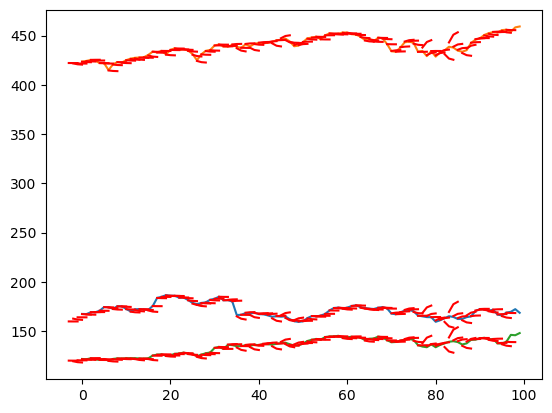

In [25]:
start_idx = -300
plt.plot(data.values[start_idx:start_idx + 100])
for idx, row in enumerate(readable[start_idx:start_idx + 100]):
    xaxis = [x for x in range(idx - 3, idx)]
    yaxis = row
    plt.plot(xaxis, yaxis, color='r')
plt.show();

#### Ramping up the parameters again

In [38]:
from keras.callbacks import EarlyStopping

def fit_lstm(train, n_lag, n_pred, n_batch, nb_epoch, n_neurons, n_seq):
    '''
    train - dataset to train on
    n_lag - number of previous days to take into account
    n_pred - number of days to predict
    n_batch - batch_size
    nb_epoch - epoch number
    n_neurons - number of neurons in the layer, probably going to be changed
    n_seq - number of sequences we are looking at
    returns -> train, test, scaler
    '''
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag * n_seq], train[:, n_lag * n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    #defining the moddel
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
    model.add(Dropout(.2))
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=False))
    model.add(Dropout(.2))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mse', optimizer='adam')
    
    callbacks = [EarlyStopping(monitor='loss', patience=2)]
    
    # fit the model
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False, callbacks=callbacks)
        model.reset_states()
    return model

In [39]:
hist_len = 32
prediction_len = 3
train, test, scaler = prep_data(data, .2, hist_len, prediction_len)

In [40]:
model = fit_lstm(train, hist_len, prediction_len, 1, 25, 50, 3)
model.summary()

3549/3549 [==============================] - 32s 9ms/step - loss: 0.0020
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (1, 1, 50)                29400     
                                                                 
 dropout_4 (Dropout)         (1, 1, 50)                0         
                                                                 
 lstm_5 (LSTM)               (1, 50)                   20200     
                                                                 
 dropout_5 (Dropout)         (1, 50)                   0         
                                                                 
 dense_2 (Dense)             (1, 9)                    459       
                                                                 
Total params: 50,059
Trainable params: 50,059
Non-trainable params: 0
___________________________________________

In [41]:
forecasts = make_forecasts(model, 1, train, test, hist_len, prediction_len, 3)

Working on 0 out of 853...
1/1 [==============================] - 1s 577ms/step
Working on 1 out of 853...
1/1 [==============================] - 0s 13ms/step
Working on 2 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 3 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 4 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 5 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 6 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 7 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 8 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 9 out of 853...
1/1 [==============================] - 0s 17ms/step
Working on 10 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 11 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 12 out of 853...
1/1 [================

1/1 [==============================] - 0s 16ms/step
Working on 103 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 104 out of 853...
1/1 [==============================] - 0s 17ms/step
Working on 105 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 106 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 107 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 108 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 109 out of 853...
1/1 [==============================] - 0s 13ms/step
Working on 110 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 111 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 112 out of 853...
1/1 [==============================] - 0s 13ms/step
Working on 113 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 114 out of 853...
1/1 [=======================

1/1 [==============================] - 0s 14ms/step
Working on 204 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 205 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 206 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 207 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 208 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 209 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 210 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 211 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 212 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 213 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 214 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 215 out of 853...
1/1 [=======================

1/1 [==============================] - 0s 16ms/step
Working on 305 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 306 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 307 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 308 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 309 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 310 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 311 out of 853...
1/1 [==============================] - 0s 18ms/step
Working on 312 out of 853...
1/1 [==============================] - 0s 18ms/step
Working on 313 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 314 out of 853...
1/1 [==============================] - 0s 18ms/step
Working on 315 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 316 out of 853...
1/1 [=======================

1/1 [==============================] - 0s 16ms/step
Working on 406 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 407 out of 853...
1/1 [==============================] - 0s 23ms/step
Working on 408 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 409 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 410 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 411 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 412 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 413 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 414 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 415 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 416 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 417 out of 853...
1/1 [=======================

1/1 [==============================] - 0s 16ms/step
Working on 507 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 508 out of 853...
1/1 [==============================] - 0s 17ms/step
Working on 509 out of 853...
1/1 [==============================] - 0s 22ms/step
Working on 510 out of 853...
1/1 [==============================] - 0s 19ms/step
Working on 511 out of 853...
1/1 [==============================] - 0s 17ms/step
Working on 512 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 513 out of 853...
1/1 [==============================] - 0s 17ms/step
Working on 514 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 515 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 516 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 517 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 518 out of 853...
1/1 [=======================

1/1 [==============================] - 0s 17ms/step
Working on 608 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 609 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 610 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 611 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 612 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 613 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 614 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 615 out of 853...
1/1 [==============================] - 0s 13ms/step
Working on 616 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 617 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 618 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 619 out of 853...
1/1 [=======================

1/1 [==============================] - 0s 16ms/step
Working on 709 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 710 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 711 out of 853...
1/1 [==============================] - 0s 23ms/step
Working on 712 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 713 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 714 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 715 out of 853...
1/1 [==============================] - 0s 17ms/step
Working on 716 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 717 out of 853...
1/1 [==============================] - 0s 17ms/step
Working on 718 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 719 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 720 out of 853...
1/1 [=======================

1/1 [==============================] - 0s 15ms/step
Working on 810 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 811 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 812 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 813 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 814 out of 853...
1/1 [==============================] - 0s 16ms/step
Working on 815 out of 853...
1/1 [==============================] - 0s 17ms/step
Working on 816 out of 853...
1/1 [==============================] - 0s 15ms/step
Working on 817 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 818 out of 853...
1/1 [==============================] - 0s 14ms/step
Working on 819 out of 853...
1/1 [==============================] - 0s 18ms/step
Working on 820 out of 853...
1/1 [==============================] - 0s 23ms/step
Working on 821 out of 853...
1/1 [=======================

In [42]:
readable = inverse_transform(data, forecasts, scaler, len(test) + 2)

In [43]:
actual = [row[hist_len * 3:] for row in test]
actual = inverse_transform(data, actual, scaler, len(test)+2, True)

evaluate_forecasts(actual, readable, hist_len, prediction_len)

t+1 RMSE_amz: 3.348928
t+1 RMSE_spy: 3.348928
t+1 RMSE_goog: 3.348928
t+2 RMSE_amz: 7.888464
t+2 RMSE_spy: 7.888464
t+2 RMSE_goog: 7.888464
t+3 RMSE_amz: 9.545428
t+3 RMSE_spy: 9.545428
t+3 RMSE_goog: 9.545428


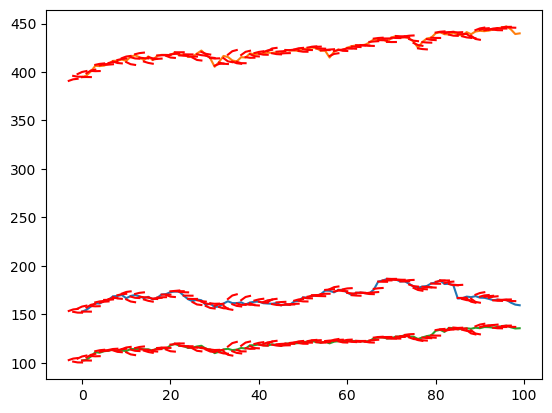

In [45]:
start_idx = -350
plt.plot(data.values[start_idx:start_idx + 100])
for idx, row in enumerate(readable[start_idx:start_idx + 100]):
    xaxis = [x for x in range(idx - 3, idx)]
    yaxis = row
    plt.plot(xaxis, yaxis, color='r')
plt.show();